# Doc2Vec model
## Reading data from CSV

In [ ]:
import pandas as pd
import ast
import re
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import hdbscan
import matplotlib.pyplot as plt
import umap

In [17]:
def parse_list_column(column):
    return ast.literal_eval(column)

csv_file = "../../data/arxiv_processed.csv"
data = pd.read_csv(csv_file, sep=";", converters={'Processed Summary': parse_list_column})

In [18]:
data.head()

,ID,Title,Summary,Published,PDF Link,Flesch reading ease,Number of words,Processed Summary
0,http://arxiv.org/abs/cs/0002002v1,Uniform semantic treatment of default and auto...,We revisit the issue of connections between tw...,2000-02-03T21:44:57Z,http://arxiv.org/pdf/cs/0002002v1,26.30,195,"[revisit, issue, connection, two, leading, for..."
1,http://arxiv.org/abs/cs/0002003v1,On the accuracy and running time of GSAT,Randomized algorithms for deciding satisfiabil...,2000-02-04T12:53:57Z,http://arxiv.org/pdf/cs/0002003v1,35.47,188,"[randomized, algorithm, deciding, satisfiabili..."
2,http://arxiv.org/abs/cs/0002009v1,Syntactic Autonomy: Why There is no Autonomy w...,Two different types of agency are discussed ba...,2000-02-16T18:09:20Z,http://arxiv.org/pdf/cs/0002009v1,22.85,160,"[two, different, type, agency, discussed, base..."
3,http://arxiv.org/abs/cs/0003008v1,Consistency Management of Normal Logic Program...,This paper presents a method of computing a re...,2000-03-05T10:29:03Z,http://arxiv.org/pdf/cs/0003008v1,45.69,127,"[paper, present, method, computing, revision, ..."
4,http://arxiv.org/abs/cs/0003016v1,Abductive and Consistency-Based Diagnosis Revi...,Diagnostic reasoning has been characterized lo...,2000-03-07T11:39:53Z,http://arxiv.org/pdf/cs/0003016v1,17.30,110,"[diagnostic, reasoning, characterized, logical..."


## Tagging Documents and Traning Doc2Vec
Once we have the processed text, we need to tag the documents. For this purpose, we will use ID column. Let's check if all the articles have the same patter of ID:

`http://arxiv.org/abs/cs/{uniqueId}`

In [21]:
total_rows = len(data)

pattern = r"http://arxiv.org/abs/cs/(\w+)"

matching_rows = 0
non_matching_rows = []
for index, row in data.iterrows():
  id = row['ID']
  if re.match(pattern, str(id)):
    matching_rows += 1
  else:
    non_matching_rows.append(index)

print(f"Total number of rows: {total_rows}")
print(f"Number of rows with matching ID pattern: {matching_rows}")
print(f"Example of non-matching ID pattern row: {data.loc[non_matching_rows[0]]['ID']}")

Total number of rows: 34575
Number of rows with matching ID pattern: 477
Example of non-matching ID pattern row: http://arxiv.org/abs/0704.2010v2


We see that we cannot use part of ID as unique TAG. So we will use number of row as id for text and train the Doc2Vec model.

In [22]:
tagged_data = [TaggedDocument(words=row['Processed Summary'], tags=[str(index)]) for index, row in data.iterrows()]

model = Doc2Vec(vector_size=100, window=5, min_count=1, workers=4, epochs=20)
model.build_vocab(tagged_data)
model.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs)

## Clustering Document Vectors
Once the model is trained, extract document vectors and apply clustering. We will use HDSCAN for simple clustering

In [23]:
vectors = [model.dv[str(index)] for index, row in data.iterrows()]

In [24]:
umap_embeddings = umap.UMAP(n_neighbors=15,
                            n_components=5,
                            metric='cosine').fit_transform(vectors)

In [25]:
cluster = hdbscan.HDBSCAN(min_cluster_size=15,
                          metric='euclidean',
                          cluster_selection_method='eom').fit(umap_embeddings)

In [26]:
umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(vectors)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

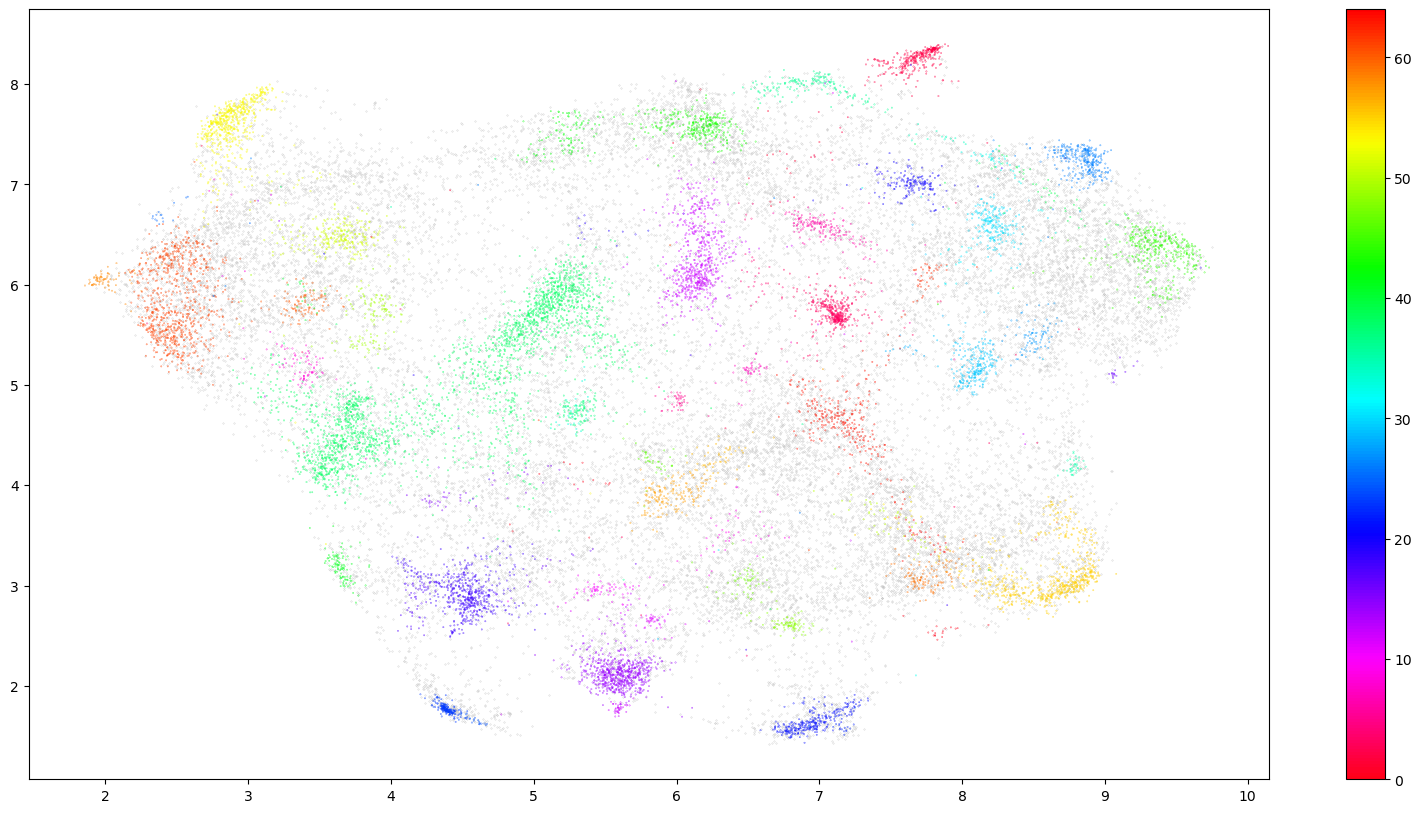

In [28]:
# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
plt.colorbar()

Number of clusters

In [29]:
len(set(cluster.labels_))

66

## Example of clusters

In [ ]:
data['cluster'] = cluster.labels_

In [45]:
cluster_number = 3

cluster_docs = data[data['cluster'] == cluster_number]

for index, row in cluster_docs.head(5).iterrows():
    print(f"Document ID: {row['ID']}")
    print(f"Title: {row['Title']}")
    print(f"Summary: {row['Summary']}")
    print(f"Cluster: {row['cluster']}")
    print("-" * 80)

Document ID: http://arxiv.org/abs/0901.4761v1
Title: A Knowledge Discovery Framework for Learning Task Models from User   Interactions in Intelligent Tutoring Systems
Summary: Domain experts should provide relevant domain knowledge to an Intelligent Tutoring System (ITS) so that it can guide a learner during problemsolving learning activities. However, for many ill-defined domains, the domain knowledge is hard to define explicitly. In previous works, we showed how sequential pattern mining can be used to extract a partial problem space from logged user interactions, and how it can support tutoring services during problem-solving exercises. This article describes an extension of this approach to extract a problem space that is richer and more adapted for supporting tutoring services. We combined sequential pattern mining with (1) dimensional pattern mining (2) time intervals, (3) the automatic clustering of valued actions and (4) closed sequences mining. Some tutoring services have been